### Prepare Data

In [ ]:
from glob import glob
from ConceptMining import ConceptMiner
from settings import settings

import pickle

In [ ]:
batch_size = 70
images = [i for i in glob("../dataset/Images/*.jpg")]
Miner = ConceptMiner(images = images, load_model= True)

# encodings, captions = Miner.get_image_caption(get_encodings = True, batch_size = batch_size)

In [ ]:
# with open('encodings.pkl', 'wb') as f:
#     pickle.dump({'encodings':encodings, 'captions': captions}, f)
with open('encodings.pkl', 'rb') as f:
	data = pickle.load(f)
	encodings = data['encodings']
	captions = data['captions']

In [ ]:
concept_model, generated_concepts = Miner.concept_modeling(encodings = encodings, 
                                                           captions = captions, 
                                                           batch_size = batch_size)

with open("generated_concepts.pkl", "wb") as f:
    pickle.dump(generated_concepts, f)


### Cluser topics by semantic similarity 
- Cluser concepts
- Sample concepts taking as mean the centroid +- a random noice to simulate user externalization

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from umap import UMAP
import os, pickle
import numpy as np

from transformers import AutoTokenizer, AutoModel

with open("generated_concepts.pkl", "rb") as f:
    generated_concepts = list(set(pickle.load(f)) - {""})
    
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embedding(sentences, model, tokenizer, batch_size = 16):
    with torch.no_grad():

        output = None
        for i in range(0, len(sentences), batch_size):
            encoded_input = tokenizer(sentences[i: i + batch_size], padding=True, return_tensors='pt')

            model_output = model(**encoded_input)
            sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            output = sentence_embeddings if output is None else torch.cat([output, sentence_embeddings])

    return output

concepts_embeddings = get_embedding(generated_concepts, model, tokenizer, batch_size = 16)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

similarity_matrix = cosine_similarity(concepts_embeddings)

# Apply Spectral Clustering
num_clusters = 20
spectral = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
labels = spectral.fit_predict(similarity_matrix)

# Group words by topic
topic_groups = {}
for word, cluster in zip(generated_concepts, labels):
    topic_groups.setdefault(cluster, []).append(word)
    
with open("generated_concepts.pkl", "wb") as f:
	pickle.dump({'concepts':generated_concepts,
              'topic_groups': topic_groups}, f)

#### Preprocess the data for simulation


In [ ]:
import pickle
from glob import glob

import random

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	data = pickle.load(f)
	encodings = data['encodings']
	captions = data['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

##### Encode all text and images to speed up training


In [6]:
from PIL import Image
import pickle
from tqdm import tqdm

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

batch_size = 70
# encode all images using output of a single text
image_encodings = []

for batch in tqdm(range(0, len(images), batch_size)):
	image = [Image.open(i) for i in images[batch: batch + batch_size]]
	inputs = processor(text=["a photo of a cat"] * len(image), images=image, return_tensors="pt", padding=True).to("cuda")
	outputs = model(**inputs, return_dict = True)
	image_encodings += [outputs.image_embeds.cpu().detach()]

image_encodings = torch.cat(image_encodings)

# encode all concepts using output of a single image
concept_encodings = []
for batch in tqdm(range(0, len(generated_concepts), batch_size)):
	concepts = generated_concepts[batch: batch + batch_size]
	inputs = processor(text=concepts, images=[Image.open(images[0])], return_tensors="pt", padding=True).to("cuda")
	outputs = model(**inputs, return_dict = True)
	concept_encodings += [outputs.text_embeds.cpu().detach()]

concept_encodings = torch.cat(concept_encodings)
with open("clip_encodings.pkl", "wb") as f:
	pickle.dump({'image_encodings': image_encodings,
			  'concept_encodings': concept_encodings}, f)

100%|██████████| 9/9 [00:00<00:00, 32.81it/s]


In [ ]:
concept_instance = {i:[] for i in generated_concepts}

for i, path in enumerate(images):
	for c in captions[i].split():
		if c in generated_concepts:
			concept_instance[c] += [path]

remove_topics = []
for i in topic_groups:
	remove = [j for j in topic_groups[i] if len(concept_instance[j]) < 10]
	for j in remove:
		topic_groups[i].remove(j)
	print(f"Topic {i}:", len(topic_groups[i]))
	if len(topic_groups[i]) < 8:
		remove_topics.append(i)

for i in remove_topics:
	del topic_groups[i]

Topic 3: 16
Topic 1: 28
Topic 0: 12
Topic 11: 24
Topic 13: 14
Topic 2: 7
Topic 9: 8
Topic 5: 20
Topic 4: 13
Topic 6: 7
Topic 8: 18
Topic 16: 15
Topic 18: 5
Topic 7: 8
Topic 19: 15
Topic 12: 8
Topic 17: 16
Topic 14: 9
Topic 10: 0
Topic 15: 7


Text(0.5, 0, 'Concepts')

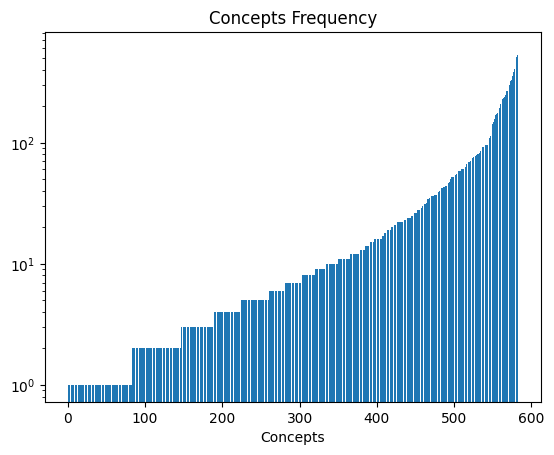

In [ ]:
from matplotlib import pyplot as plt	
plt.bar(range(len(generated_concepts)), sorted([len(i) for i in concept_instance.values()]), log = True)
plt.title("Concepts Frequency")
plt.xlabel("Concepts")

Text(0.5, 0, 'Topics')

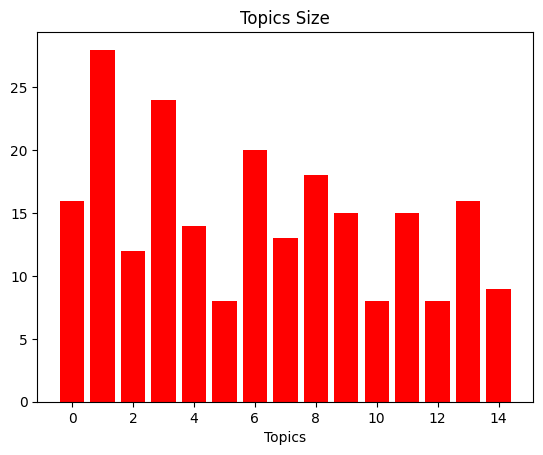

In [ ]:
plt.bar(range(len(topic_groups)), [len(topic_groups[i]) for i in topic_groups], color = 'r')
plt.title("Topics Size")
plt.xlabel("Topics")

In [ ]:
import gymnasium as gym
from matplotlib import pyplot as plt

from ConceptPrompting import AdaptationEngine
from tqdm import tqdm
import torch


def encode_actions(action, n_actions):

	if not isinstance(action, torch.Tensor):
		action = torch.tensor(action)
	return torch.nn.functional.one_hot(action, num_classes=n_actions).float()

def preprocess_state(state):
	return torch.tensor(state).float().reshape(1, -1)

def get_entropy(preferences):
	return -torch.sum(preferences * torch.log(preferences), dim = -1)

episodes = 400
episode_length = 1000
dataset_coverage_step = .75
gamma = 0.99
buffer = []
actions_embedd_dim = 2
buffer_size = 512

lr_actor = 0.001
lr_critic = 0.0001

temperature = 2.0
final_temperature = 0.1
decay_rate = 0.99  # Decay per episode

# env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')

# Pi = Actor(state_dim = env.observation_space.shape[0], action_dim = actions_embedd_dim, lr_optimizer = lr_actor)
# V = Critic(state_dim = env.observation_space.shape[0], lr_optimizer = lr_critic)
Agent = AdaptationEngine(state_dim = env.observation_space.shape[0],
						 	action_dim=env.action_space.n,
							lr_actor = lr_actor,
							lr_critic = lr_critic,
							gamma = gamma,
							buffer_size = buffer_size,
							sample_temperature = temperature,
							final_temperature = final_temperature,
							temperatura_decay = decay_rate)

actions_encode = encode_actions([i  for i in range(env.action_space.n)], env.action_space.n).to(Agent.device)

episode_history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}

history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}


for episode in range(episodes):

	prev_state, _ = env.reset()
	prev_state = preprocess_state(prev_state)

	episode_history = {'rewards': [],
		'loss_critic': [], 
		'loss_actor': [],
		'entropy': []}
			
	itera = tqdm(range(episode_length))
	itera.set_description(f"Episode {episode}")
	
	for step in itera:

		preferences = Agent.policy(prev_state, actions_encode)	
		action = torch.multinomial(preferences, 1).squeeze(-1)
		
		state, reward, done, truncated, _ = env.step(action.item())
		state = preprocess_state(state)

		Agent.push_buffer(state=prev_state,
					 action=action, 
					 reward=reward, 
					 next_state=state, 
					 done=done)
		
		episode_history['rewards'].append(reward)
		episode_history['entropy'].append(get_entropy(preferences).mean().item())

		if Agent.buffer_size <= len(Agent.buffer):
			actor_loss, critic_loss = Agent.optimization_step(actions_encode)
			episode_history['loss_critic'].append(critic_loss)
			episode_history['loss_actor'].append(actor_loss)

		prev_state = state

		itera.set_postfix({'Temperature': f'{temperature:.4f}',
						'Reward': sum(episode_history['rewards']),
						'entropy': sum(episode_history['entropy']),
						'Loss Critic': sum(episode_history['loss_critic']),
						'Loss Actor': sum(episode_history['loss_actor'])} )
		if done or truncated:
			history['rewards'].append(sum(episode_history['rewards']))
			history['loss_critic'].append(sum(episode_history['loss_critic']))
			history['loss_actor'].append(sum(episode_history['loss_actor']))
			break

	temperature = max(final_temperature, temperature * decay_rate)
	if Agent.max_reward is None or Agent.max_reward < sum(episode_history['rewards']):
		Agent.max_reward = sum(episode_history['rewards'])
		Agent.Actor.save(f"actor.pt")
		Agent.Critic.save(f"critic.pt")

env.close()

Text(0.5, 0, 'Iterations')

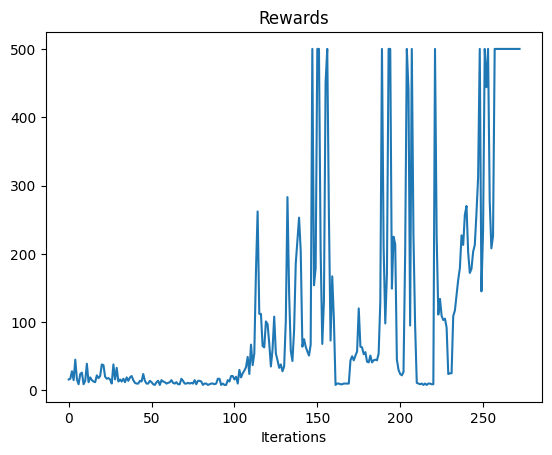

In [ ]:
plt.plot(history['rewards'])
plt.title("Rewards")
plt.xlabel("Iterations")

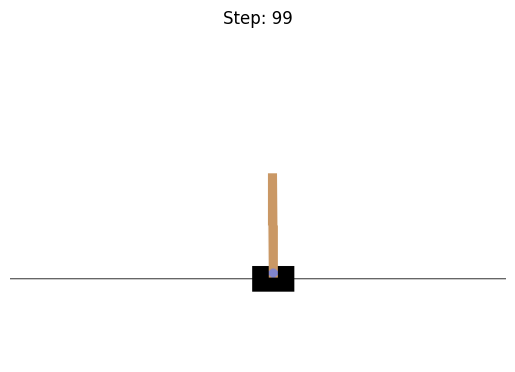

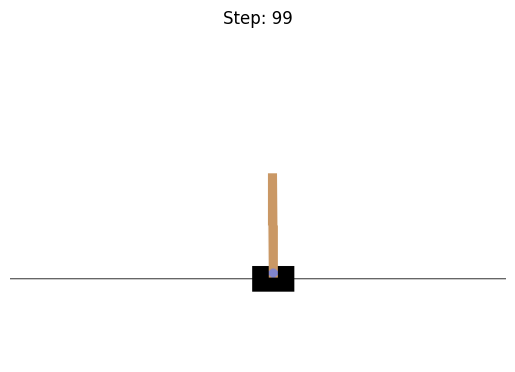

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(env, step=0):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title(f"Step: {step}")
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


env = gym.make('CartPole-v1', render_mode='rgb_array')
Agent = AdaptationEngine(state_dim = env.observation_space.shape[0],
							action_dim=env.action_space.n)
                            
Agent.Actor.load('actor.pt')
# env = gym.make('MountainCar-v0', render_mode='rgb_array')

prev_state, info = env.reset()
prev_state = preprocess_state(prev_state)
print(prev_state)
for step in range(int(100)):
	preferences =  Agent.policy(prev_state, actions_encode)

	action = preferences.argmax()

	observation, reward, terminated, _, _ = env.step(action.item())
	print(action)

	prev_state = preprocess_state(observation)
	prev_action = action

	show_state(env, step=step)

	if terminated:
		print(observation)
		break

env.close()


### Exploration Agent

In [1]:
import pickle
from matplotlib import pyplot as plt
from glob import glob

from ConceptPrompting import AdaptationEngine, explore_environment
from settings import  pretraining_settings as settings
from tqdm import tqdm
import torch
import numpy as np

def get_entropy(preferences):
	return -torch.sum(preferences * torch.log(preferences), dim = -1)

with open("clip_encodings.pkl", "rb") as f:
	data = pickle.load(f)
	image_encodings = data['image_encodings']
	actions_encode = data['concept_encodings']

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	captions = pickle.load(f)['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

Agent = AdaptationEngine(state_dim = image_encodings.shape[1] + actions_encode.shape[1],
						 	action_dim=actions_encode.shape[1],
							lr_actor = settings.lr_actor,
							lr_critic = settings.lr_critic,
							gamma = settings.gamma,
							buffer_size = settings.buffer_size,
							sample_temperature = settings.temperature,
							final_temperature = settings.final_temperature,
							temperature_decay = settings.decay_rate)


env = explore_environment(topic_groups=topic_groups, 
						  concepts=generated_concepts,
						  concepts_encode=actions_encode,
						  images=images,
						  images_caption=captions,
						  images_encode=image_encodings, 
						  threshold=10)


#-----------------------------------------------------------------------------

episode_history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}

history = {'rewards': [],
		   'episodes_rewards': {},
		    'loss_critic': [], 
			'loss_actor': []}

average_reward = [0]

for episode in range(settings.episodes):

	episode_index, (prev_state, feedback, _) = env.reset()
	prev_state = env.preprocess_state(prev_state)

	env.externalized.add(feedback)

	episode_history = {'rewards': [],
		'loss_critic': [], 
		'loss_actor': [],
		'entropy': []}
	if episode_index not in history['episodes_rewards']:
		history['episodes_rewards'][episode_index] = []
			
	itera = tqdm(range(len(env.topic)))
	itera.set_description(f"Episode {episode}")

	
	for step in itera:

		preferences = Agent.policy(prev_state, actions_encode)
		# print(prev_state)
		# print(preferences)	
		action = torch.multinomial(preferences, 1).squeeze(-1)
		
		state, feedback, reward, done = env.step( action.item() )
		state = env.preprocess_state(state)
		env.externalized.add(feedback)

		Agent.push_buffer(state=prev_state,
					 action=action, 
					 reward=reward, 
					 next_state=state, 
					 done=done)
		
		episode_history['rewards'].append(reward)
		episode_history['entropy'].append(get_entropy(preferences).mean().item())

		if Agent.buffer_size <= len(Agent.buffer):
			actor_loss, critic_loss = Agent.optimization_step(actions_encode)
			episode_history['loss_critic'].append(critic_loss)
			episode_history['loss_actor'].append(actor_loss)

		prev_state = state

		itera.set_postfix({'Temp': f'{Agent.temperature:.4f}',
					 	'Avg. Reward': f"{average_reward[-1]:.4f}",
						'Reward': sum(episode_history['rewards']),
						'entropy': sum(episode_history['entropy']),
						'L Critic': sum(episode_history['loss_critic']),
						'L Actor': sum(episode_history['loss_actor'])} )
		if done:
			history['rewards'].append(sum(episode_history['rewards']))
			history['loss_critic'].append(sum(episode_history['loss_critic']))
			history['loss_actor'].append(sum(episode_history['loss_actor']))
			break

	Agent.temperature = max(Agent.final_temperature, Agent.temperature * Agent.temperature_decay)

	average_reward += [np.mean([np.mean(history['episodes_rewards'][i]) for i in history['episodes_rewards'].keys()]) \
		if len(history['episodes_rewards']) ==  len(env.topic_groups) else -1]

	if Agent.max_reward is None or Agent.max_reward < average_reward[-1]:
		Agent.max_reward = average_reward[-1]
		Agent.Actor.save(f"actor.pt")
		Agent.Critic.save(f"critic.pt")
		print(f"Model saved - {average_reward[-1]:.2f}")
	history['episodes_rewards'][episode_index].append(sum(episode_history['rewards']).item())

# env.close()

Topic 3: 16
Topic 1: 28
Topic 0: 12
Topic 11: 24
Topic 13: 14
Topic 9: 8
Topic 5: 20
Topic 4: 13
Topic 8: 18
Topic 16: 15
Topic 7: 8
Topic 19: 15
Topic 12: 8
Topic 17: 16
Topic 14: 9


Episode 0:  95%|█████████▌| 19/20 [00:02<00:00,  7.96it/s, Temp=5.0000, Avg. Reward=0.0000, Reward=28.3, entropy=127, L Critic=0, L Actor=0] 


Model saved - -1.00


Episode 36:  94%|█████████▍| 17/18 [00:01<00:00,  8.51it/s, Temp=3.4821, Avg. Reward=-1.0000, Reward=25.7, entropy=2.41, L Critic=-46.7, L Actor=527] 
/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Episode 37:  94%|█████████▍| 15/16 [00:01<00:00,  8.43it/s, Temp=3.4472, Avg. Reward=nan, Reward=22.6, entropy=6.83, L Critic=-41, L Actor=473]    


Model saved - 20.88


Episode 41:  93%|█████████▎| 14/15 [00:01<00:00,  8.91it/s, Temp=3.3114, Avg. Reward=20.8740, Reward=21.5, entropy=0.267, L Critic=-33.6, L Actor=544]


Model saved - 20.88


Episode 42:  93%|█████████▎| 14/15 [00:01<00:00,  8.91it/s, Temp=3.2783, Avg. Reward=20.8834, Reward=21.1, entropy=2.29, L Critic=-64.6, L Actor=572]


Model saved - 20.89


Episode 43:  93%|█████████▎| 14/15 [00:01<00:00,  8.83it/s, Temp=3.2455, Avg. Reward=20.8948, Reward=21, entropy=0.489, L Critic=-66.4, L Actor=588]  


Model saved - 20.90


Episode 44:  89%|████████▉ | 8/9 [00:00<00:00,  9.00it/s, Temp=3.2131, Avg. Reward=20.8987, Reward=12.2, entropy=0.203, L Critic=-1.77, L Actor=335] 


Model saved - 20.90


Episode 45:  94%|█████████▍| 15/16 [00:01<00:00,  8.40it/s, Temp=3.1809, Avg. Reward=20.8994, Reward=22.7, entropy=0.121, L Critic=0.197, L Actor=543]


Model saved - 20.90


Episode 46:  94%|█████████▍| 15/16 [00:01<00:00,  8.40it/s, Temp=3.1491, Avg. Reward=20.9013, Reward=22.8, entropy=0.0548, L Critic=0.093, L Actor=560]  


Model saved - 20.92


Episode 47:  89%|████████▉ | 8/9 [00:00<00:00,  8.47it/s, Temp=3.1176, Avg. Reward=20.9162, Reward=12.3, entropy=0.0356, L Critic=0.0385, L Actor=347]  


Model saved - 20.92


Episode 48:  94%|█████████▍| 15/16 [00:01<00:00,  8.76it/s, Temp=3.0865, Avg. Reward=20.9231, Reward=22.7, entropy=0.0316, L Critic=0.0535, L Actor=619]


Model saved - 20.92


Episode 49:  92%|█████████▏| 11/12 [00:01<00:00,  9.49it/s, Temp=3.0556, Avg. Reward=20.9249, Reward=17, entropy=0.0226, L Critic=0.0292, L Actor=448]   


Model saved - 20.93


Episode 50:  93%|█████████▎| 14/15 [00:01<00:00,  8.63it/s, Temp=3.0250, Avg. Reward=20.9273, Reward=21.2, entropy=0.019, L Critic=0.0301, L Actor=593]  


Model saved - 20.94


Episode 51:  95%|█████████▌| 19/20 [00:02<00:00,  8.57it/s, Temp=2.9948, Avg. Reward=20.9375, Reward=29, entropy=0.0167, L Critic=0.0313, L Actor=791]   


Model saved - 20.94


Episode 52:  96%|█████████▌| 23/24 [00:02<00:00,  8.69it/s, Temp=2.9648, Avg. Reward=20.9407, Reward=35.2, entropy=0.0151, L Critic=0.025, L Actor=840]  


Model saved - 20.95


Episode 53:  94%|█████████▍| 17/18 [00:01<00:00,  8.69it/s, Temp=2.9352, Avg. Reward=20.9534, Reward=26, entropy=0.0132, L Critic=0.015, L Actor=631]    


Model saved - 20.97


Episode 54:  92%|█████████▏| 11/12 [00:01<00:00,  9.06it/s, Temp=2.9058, Avg. Reward=20.9730, Reward=16.9, entropy=0.00995, L Critic=0.00878, L Actor=446]


Model saved - 20.98


Episode 55:  93%|█████████▎| 13/14 [00:01<00:00,  8.54it/s, Temp=2.8768, Avg. Reward=20.9825, Reward=20.1, entropy=0.00932, L Critic=0.0109, L Actor=650] 


Model saved - 20.99


Episode 56:  92%|█████████▏| 11/12 [00:01<00:00,  8.30it/s, Temp=2.8480, Avg. Reward=20.9863, Reward=16.9, entropy=0.00883, L Critic=0.009, L Actor=629]   


Model saved - 20.99


Episode 57:  95%|█████████▌| 19/20 [00:02<00:00,  8.73it/s, Temp=2.8195, Avg. Reward=20.9936, Reward=28.8, entropy=0.00783, L Critic=0.0137, L Actor=1.11e+3]


Model saved - 21.00


Episode 58:  93%|█████████▎| 13/14 [00:01<00:00,  8.98it/s, Temp=2.7913, Avg. Reward=20.9963, Reward=19.9, entropy=0.00662, L Critic=0.00794, L Actor=751]


Model saved - 21.00


Episode 59:  94%|█████████▍| 17/18 [00:02<00:00,  8.32it/s, Temp=2.7634, Avg. Reward=21.0018, Reward=26, entropy=0.00754, L Critic=0.00871, L Actor=887]  


Model saved - 21.01


Episode 60:  95%|█████████▌| 19/20 [00:02<00:00,  8.97it/s, Temp=2.7358, Avg. Reward=21.0050, Reward=28.9, entropy=0.00681, L Critic=0.00731, L Actor=849] 


Model saved - 21.01


Episode 61:  96%|█████████▋| 27/28 [00:03<00:00,  8.34it/s, Temp=2.7084, Avg. Reward=21.0068, Reward=42.1, entropy=0.00645, L Critic=0.00836, L Actor=1.17e+3]


Model saved - 21.01


Episode 62:  96%|█████████▌| 23/24 [00:02<00:00,  8.73it/s, Temp=2.6813, Avg. Reward=21.0115, Reward=35.1, entropy=0.00634, L Critic=0.00535, L Actor=937] 


Model saved - 21.04


Episode 63:  94%|█████████▍| 17/18 [00:01<00:00,  8.73it/s, Temp=2.6545, Avg. Reward=21.0429, Reward=26, entropy=0.00501, L Critic=0.00386, L Actor=824]   


Model saved - 21.05


Episode 64:  93%|█████████▎| 14/15 [00:01<00:00,  8.45it/s, Temp=2.6280, Avg. Reward=21.0516, Reward=21.2, entropy=0.00456, L Critic=0.0036, L Actor=862] 


Model saved - 21.05


Episode 65:  94%|█████████▍| 15/16 [00:01<00:00,  8.80it/s, Temp=2.6017, Avg. Reward=21.0525, Reward=22.7, entropy=0.00448, L Critic=0.0039, L Actor=1.04e+3]


Model saved - 21.05


Episode 66:  96%|█████████▋| 27/28 [00:03<00:00,  8.35it/s, Temp=2.5757, Avg. Reward=21.0543, Reward=42, entropy=0.00501, L Critic=0.00555, L Actor=1.73e+3]  


Model saved - 21.06


Episode 67:  93%|█████████▎| 14/15 [00:01<00:00,  8.44it/s, Temp=2.5499, Avg. Reward=21.0563, Reward=21.5, entropy=0.00336, L Critic=0.00227, L Actor=833]


Model saved - 21.07


Episode 68:  94%|█████████▍| 17/18 [00:01<00:00,  8.55it/s, Temp=2.5244, Avg. Reward=21.0710, Reward=26.1, entropy=0.00361, L Critic=0.00221, L Actor=971]


Model saved - 21.08


Episode 69:  93%|█████████▎| 14/15 [00:01<00:00,  9.03it/s, Temp=2.4992, Avg. Reward=21.0774, Reward=21.4, entropy=0.00296, L Critic=0.00153, L Actor=791]


Model saved - 21.08


Episode 70:  93%|█████████▎| 13/14 [00:01<00:00,  8.37it/s, Temp=2.4742, Avg. Reward=21.0797, Reward=20.1, entropy=0.00303, L Critic=0.00167, L Actor=927]


Model saved - 21.08


Episode 71:  96%|█████████▋| 27/28 [00:03<00:00,  8.55it/s, Temp=2.4495, Avg. Reward=21.0825, Reward=42.1, entropy=0.00432, L Critic=0.00269, L Actor=1.51e+3]


Model saved - 21.09


Episode 72:  96%|█████████▌| 23/24 [00:02<00:00,  8.65it/s, Temp=2.4250, Avg. Reward=21.0865, Reward=35, entropy=0.00386, L Critic=0.00188, L Actor=1.1e+3]   


Model saved - 21.10


Episode 73:  93%|█████████▎| 14/15 [00:01<00:00,  8.71it/s, Temp=2.4007, Avg. Reward=21.0962, Reward=21.2, entropy=0.00255, L Critic=0.000927, L Actor=664]


Model saved - 21.10


Episode 74:  89%|████████▉ | 8/9 [00:01<00:00,  7.91it/s, Temp=2.3767, Avg. Reward=21.1002, Reward=12.3, entropy=0.00184, L Critic=0.00052, L Actor=460]  


Model saved - 21.10


Episode 75:  93%|█████████▎| 14/15 [00:01<00:00,  8.76it/s, Temp=2.3529, Avg. Reward=21.1021, Reward=21.2, entropy=0.00243, L Critic=0.00104, L Actor=997] 


Model saved - 21.10


Episode 76:  95%|█████████▌| 19/20 [00:02<00:00,  8.74it/s, Temp=2.3294, Avg. Reward=21.1032, Reward=28.9, entropy=0.00294, L Critic=0.00118, L Actor=1.22e+3]


Model saved - 21.10


Episode 77:  93%|█████████▎| 14/15 [00:01<00:00,  8.96it/s, Temp=2.3061, Avg. Reward=21.1044, Reward=21.2, entropy=0.00237, L Critic=0.000811, L Actor=865]


Model saved - 21.11


Episode 78:  88%|████████▊ | 7/8 [00:00<00:00,  9.12it/s, Temp=2.2830, Avg. Reward=21.1073, Reward=10.8, entropy=0.00148, L Critic=0.000399, L Actor=456] 


Model saved - 21.11


Episode 79:  92%|█████████▏| 12/13 [00:01<00:00,  8.87it/s, Temp=2.2602, Avg. Reward=21.1082, Reward=18.4, entropy=0.00195, L Critic=0.000556, L Actor=680]


Model saved - 21.11


Episode 80:  89%|████████▉ | 8/9 [00:00<00:00,  8.66it/s, Temp=2.2376, Avg. Reward=21.1126, Reward=12.3, entropy=0.00144, L Critic=0.000346, L Actor=480]


Model saved - 21.12


Episode 81:  92%|█████████▏| 11/12 [00:01<00:00,  8.86it/s, Temp=2.2152, Avg. Reward=21.1168, Reward=16.9, entropy=0.00181, L Critic=0.0004, L Actor=606]  


Model saved - 21.12


Episode 82:  94%|█████████▍| 15/16 [00:01<00:00,  8.73it/s, Temp=2.1931, Avg. Reward=21.1174, Reward=22.7, entropy=0.00222, L Critic=0.000501, L Actor=780]


Model saved - 21.12


Episode 83:  94%|█████████▍| 15/16 [00:01<00:00,  8.38it/s, Temp=2.1712, Avg. Reward=21.1192, Reward=23.1, entropy=0.00211, L Critic=0.000403, L Actor=669]


Model saved - 21.12


Episode 84:  96%|█████████▌| 23/24 [00:02<00:00,  8.58it/s, Temp=2.1494, Avg. Reward=21.1201, Reward=35.2, entropy=0.0029, L Critic=0.000421, L Actor=783] 


Model saved - 21.13


Episode 85:  96%|█████████▋| 27/28 [00:03<00:00,  8.81it/s, Temp=2.1280, Avg. Reward=21.1298, Reward=41.7, entropy=0.0033, L Critic=0.000337, L Actor=782] 


Model saved - 21.13


Episode 86:  92%|█████████▏| 12/13 [00:01<00:00,  8.87it/s, Temp=2.1067, Avg. Reward=21.1346, Reward=18.4, entropy=0.00166, L Critic=0.000137, L Actor=418]


Model saved - 21.14


Episode 87:  96%|█████████▌| 23/24 [00:02<00:00,  8.57it/s, Temp=2.0856, Avg. Reward=21.1374, Reward=35, entropy=0.00279, L Critic=0.000234, L Actor=890]  


Model saved - 21.14


Episode 88:  96%|█████████▋| 27/28 [00:03<00:00,  8.39it/s, Temp=2.0647, Avg. Reward=21.1405, Reward=41.9, entropy=0.00319, L Critic=0.000248, L Actor=1.19e+3]


Model saved - 21.14


Episode 89:  94%|█████████▍| 15/16 [00:01<00:00,  8.70it/s, Temp=2.0441, Avg. Reward=21.1415, Reward=22.9, entropy=0.00194, L Critic=0.000135, L Actor=697]


Model saved - 21.14


Episode 90:  88%|████████▊ | 7/8 [00:00<00:00,  9.04it/s, Temp=2.0237, Avg. Reward=21.1448, Reward=10.7, entropy=0.00105, L Critic=7.03e-5, L Actor=413]  


Model saved - 21.15


Episode 91:  88%|████████▊ | 7/8 [00:00<00:00,  9.00it/s, Temp=2.0034, Avg. Reward=21.1476, Reward=10.8, entropy=0.00102, L Critic=8.23e-5, L Actor=536] 


Model saved - 21.15


Episode 92:  93%|█████████▎| 14/15 [00:01<00:00,  8.50it/s, Temp=1.9834, Avg. Reward=21.1513, Reward=21.6, entropy=0.00179, L Critic=0.000149, L Actor=950]


Model saved - 21.15


Episode 93:  96%|█████████▌| 23/24 [00:02<00:00,  8.39it/s, Temp=1.9636, Avg. Reward=21.1540, Reward=35.1, entropy=0.00268, L Critic=0.000193, L Actor=1.36e+3]


Model saved - 21.16


Episode 94:  88%|████████▊ | 7/8 [00:00<00:00,  8.57it/s, Temp=1.9439, Avg. Reward=21.1574, Reward=10.7, entropy=0.000982, L Critic=5.11e-5, L Actor=405]


Model saved - 21.16


Episode 95:  88%|████████▊ | 7/8 [00:00<00:00,  8.95it/s, Temp=1.9245, Avg. Reward=21.1595, Reward=10.8, entropy=0.000955, L Critic=4.51e-5, L Actor=374]


Model saved - 21.16


Episode 96:  89%|████████▉ | 8/9 [00:00<00:00,  8.29it/s, Temp=1.9052, Avg. Reward=21.1603, Reward=12.2, entropy=0.00106, L Critic=4.28e-5, L Actor=392]  


Model saved - 21.16


Episode 98:  93%|█████████▎| 14/15 [00:01<00:00,  8.78it/s, Temp=1.8673, Avg. Reward=21.1629, Reward=21.5, entropy=0.00169, L Critic=4.52e-5, L Actor=548] 


Model saved - 21.17


Episode 99:  93%|█████████▎| 14/15 [00:01<00:00,  8.93it/s, Temp=1.8486, Avg. Reward=21.1668, Reward=21.2, entropy=0.00168, L Critic=3.59e-5, L Actor=470]


Model saved - 21.17


Episode 100:  96%|█████████▋| 27/28 [00:03<00:00,  8.66it/s, Temp=1.8302, Avg. Reward=21.1686, Reward=41.9, entropy=0.00306, L Critic=4.71e-5, L Actor=816] 


Model saved - 21.17


Episode 101:  93%|█████████▎| 14/15 [00:01<00:00,  8.32it/s, Temp=1.8119, Avg. Reward=21.1698, Reward=21.4, entropy=0.00167, L Critic=2.63e-5, L Actor=532] 


Model saved - 21.17


Episode 102:  94%|█████████▍| 15/16 [00:01<00:00,  8.82it/s, Temp=1.7937, Avg. Reward=21.1718, Reward=22.8, entropy=0.00177, L Critic=2.61e-5, L Actor=592] 


Model saved - 21.17


Episode 103:  96%|█████████▌| 23/24 [00:02<00:00,  8.26it/s, Temp=1.7758, Avg. Reward=21.1727, Reward=35, entropy=0.00262, L Critic=3.12e-5, L Actor=885]   


Model saved - 21.17


Episode 104:  94%|█████████▍| 15/16 [00:01<00:00,  8.82it/s, Temp=1.7580, Avg. Reward=21.1734, Reward=22.7, entropy=0.00175, L Critic=2.11e-5, L Actor=669] 


Model saved - 21.17


Episode 105:  89%|████████▉ | 8/9 [00:00<00:00,  9.02it/s, Temp=1.7405, Avg. Reward=21.1741, Reward=12.3, entropy=0.001, L Critic=1.05e-5, L Actor=400]    


Model saved - 21.17


Episode 106:  89%|████████▉ | 8/9 [00:00<00:00,  9.14it/s, Temp=1.7231, Avg. Reward=21.1745, Reward=12.3, entropy=0.000996, L Critic=8.32e-6, L Actor=398] 


Model saved - 21.17


Episode 107:  92%|█████████▏| 12/13 [00:01<00:00,  8.55it/s, Temp=1.7058, Avg. Reward=21.1749, Reward=18.3, entropy=0.00142, L Critic=1.04e-5, L Actor=567]


Model saved - 21.17


Episode 108:  94%|█████████▍| 15/16 [00:01<00:00,  8.19it/s, Temp=1.6888, Avg. Reward=21.1750, Reward=22.6, entropy=0.00174, L Critic=1.19e-5, L Actor=706] 


Model saved - 21.18


Episode 110:  93%|█████████▎| 14/15 [00:01<00:00,  8.44it/s, Temp=1.6552, Avg. Reward=21.1761, Reward=21.1, entropy=0.00163, L Critic=7.24e-6, L Actor=476] 


Model saved - 21.18


Episode 111:  94%|█████████▍| 17/18 [00:02<00:00,  8.47it/s, Temp=1.6386, Avg. Reward=21.1782, Reward=26.1, entropy=0.00195, L Critic=6.61e-6, L Actor=532] 


Model saved - 21.18


Episode 112:  94%|█████████▍| 15/16 [00:01<00:00,  8.16it/s, Temp=1.6222, Avg. Reward=21.1787, Reward=22.7, entropy=0.00173, L Critic=5.25e-6, L Actor=494] 


Model saved - 21.18


Episode 113:  92%|█████████▏| 12/13 [00:01<00:00,  8.41it/s, Temp=1.6060, Avg. Reward=21.1803, Reward=18.4, entropy=0.00141, L Critic=3.77e-6, L Actor=449] 


Model saved - 21.18


Episode 114:  93%|█████████▎| 13/14 [00:01<00:00,  8.91it/s, Temp=1.5899, Avg. Reward=21.1805, Reward=20, entropy=0.00151, L Critic=2.91e-6, L Actor=474]   


Model saved - 21.18


Episode 115:  88%|████████▊ | 7/8 [00:00<00:00,  9.33it/s, Temp=1.5740, Avg. Reward=21.1825, Reward=10.7, entropy=0.000868, L Critic=1.47e-6, L Actor=277] 


Model saved - 21.18


Episode 116:  96%|█████████▋| 27/28 [00:03<00:00,  8.41it/s, Temp=1.5583, Avg. Reward=21.1845, Reward=41.9, entropy=0.00302, L Critic=5.03e-6, L Actor=941] 


Model saved - 21.18


Episode 117:  89%|████████▉ | 8/9 [00:00<00:00,  8.64it/s, Temp=1.5427, Avg. Reward=21.1848, Reward=12.3, entropy=0.000974, L Critic=1.24e-6, L Actor=275] 


Model saved - 21.19


Episode 118:  93%|█████████▎| 13/14 [00:01<00:00,  8.65it/s, Temp=1.5273, Avg. Reward=21.1862, Reward=20, entropy=0.00151, L Critic=1.83e-6, L Actor=436]  


Model saved - 21.19


Episode 119:  92%|█████████▏| 12/13 [00:01<00:00,  8.73it/s, Temp=1.5120, Avg. Reward=21.1864, Reward=18.2, entropy=0.0014, L Critic=1.59e-6, L Actor=397]  


Model saved - 21.19


Episode 120:  93%|█████████▎| 14/15 [00:01<00:00,  8.66it/s, Temp=1.4969, Avg. Reward=21.1882, Reward=21.5, entropy=0.00162, L Critic=1.33e-6, L Actor=416] 


Model saved - 21.19


Episode 121:  94%|█████████▍| 17/18 [00:01<00:00,  8.64it/s, Temp=1.4819, Avg. Reward=21.1889, Reward=26.1, entropy=0.00194, L Critic=1.33e-6, L Actor=556] 


Model saved - 21.19


Episode 122:  93%|█████████▎| 14/15 [00:01<00:00,  8.63it/s, Temp=1.4671, Avg. Reward=21.1898, Reward=21.1, entropy=0.00162, L Critic=9.59e-7, L Actor=412] 


Model saved - 21.19


Episode 123:  93%|█████████▎| 14/15 [00:01<00:00,  8.58it/s, Temp=1.4524, Avg. Reward=21.1905, Reward=21.3, entropy=0.00161, L Critic=1.02e-6, L Actor=421] 


Model saved - 21.19


Episode 124:  93%|█████████▎| 14/15 [00:01<00:00,  8.22it/s, Temp=1.4379, Avg. Reward=21.1907, Reward=21.2, entropy=0.00161, L Critic=6.02e-7, L Actor=425] 


Model saved - 21.19


Episode 125:  88%|████████▊ | 7/8 [00:00<00:00,  9.16it/s, Temp=1.4235, Avg. Reward=21.1917, Reward=10.8, entropy=0.000861, L Critic=2.84e-7, L Actor=237]


Model saved - 21.19


Episode 126:  94%|█████████▍| 17/18 [00:02<00:00,  8.13it/s, Temp=1.4093, Avg. Reward=21.1920, Reward=26, entropy=0.00193, L Critic=6.62e-7, L Actor=569]   


Model saved - 21.19


Episode 128:  89%|████████▉ | 8/9 [00:00<00:00,  9.10it/s, Temp=1.3813, Avg. Reward=21.1931, Reward=12.3, entropy=0.000968, L Critic=2.51e-7, L Actor=278]


Model saved - 21.19


Episode 129:  88%|████████▊ | 7/8 [00:00<00:00,  9.03it/s, Temp=1.3674, Avg. Reward=21.1943, Reward=10.7, entropy=0.00086, L Critic=2.08e-7, L Actor=252]  


Model saved - 21.19


Episode 130:  94%|█████████▍| 15/16 [00:01<00:00,  8.63it/s, Temp=1.3538, Avg. Reward=21.1943, Reward=23.1, entropy=0.00172, L Critic=2.49e-7, L Actor=455] 


Model saved - 21.19


Episode 131:  94%|█████████▍| 17/18 [00:02<00:00,  8.30it/s, Temp=1.3402, Avg. Reward=21.1948, Reward=26, entropy=0.00193, L Critic=0, L Actor=418]   


Model saved - 21.20


Episode 132:  95%|█████████▌| 19/20 [00:02<00:00,  8.31it/s, Temp=1.3268, Avg. Reward=21.1993, Reward=28.9, entropy=0.00215, L Critic=0, L Actor=406] 


Model saved - 21.20


Episode 133:  94%|█████████▍| 17/18 [00:02<00:00,  8.48it/s, Temp=1.3136, Avg. Reward=21.1994, Reward=26.1, entropy=0.00193, L Critic=0, L Actor=326] 


Model saved - 21.20


Episode 134:  92%|█████████▏| 12/13 [00:01<00:00,  8.34it/s, Temp=1.3004, Avg. Reward=21.2011, Reward=18.4, entropy=0.0014, L Critic=0, L Actor=275]  


Model saved - 21.20


Episode 135:  94%|█████████▍| 15/16 [00:01<00:00,  8.97it/s, Temp=1.2874, Avg. Reward=21.2016, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=385] 


Model saved - 21.20


Episode 136:  93%|█████████▎| 14/15 [00:01<00:00,  8.56it/s, Temp=1.2745, Avg. Reward=21.2033, Reward=21.3, entropy=0.00161, L Critic=0, L Actor=428] 


Model saved - 21.21


Episode 137:  92%|█████████▏| 12/13 [00:01<00:00,  8.64it/s, Temp=1.2618, Avg. Reward=21.2059, Reward=18.4, entropy=0.0014, L Critic=0, L Actor=370]  


Model saved - 21.21


Episode 138:  92%|█████████▏| 12/13 [00:01<00:00,  8.75it/s, Temp=1.2492, Avg. Reward=21.2069, Reward=18.4, entropy=0.0014, L Critic=0, L Actor=382]  


Model saved - 21.21


Episode 139:  89%|████████▉ | 8/9 [00:00<00:00,  9.11it/s, Temp=1.2367, Avg. Reward=21.2079, Reward=12.3, entropy=0.000967, L Critic=0, L Actor=260] 


Model saved - 21.21


Episode 140:  88%|████████▊ | 7/8 [00:00<00:00,  8.47it/s, Temp=1.2243, Avg. Reward=21.2088, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=229] 


Model saved - 21.21


Episode 141:  92%|█████████▏| 11/12 [00:01<00:00,  8.60it/s, Temp=1.2121, Avg. Reward=21.2091, Reward=16.9, entropy=0.00129, L Critic=0, L Actor=334] 


Model saved - 21.21


Episode 142:  94%|█████████▍| 15/16 [00:01<00:00,  8.50it/s, Temp=1.2000, Avg. Reward=21.2109, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=389] 


Model saved - 21.21


Episode 143:  92%|█████████▏| 12/13 [00:01<00:00,  8.66it/s, Temp=1.1880, Avg. Reward=21.2119, Reward=18.4, entropy=0.0014, L Critic=0, L Actor=291]  


Model saved - 21.21


Episode 144:  92%|█████████▏| 11/12 [00:01<00:00,  8.86it/s, Temp=1.1761, Avg. Reward=21.2146, Reward=17, entropy=0.00129, L Critic=0, L Actor=252]   


Model saved - 21.22


Episode 145:  92%|█████████▏| 11/12 [00:01<00:00,  8.66it/s, Temp=1.1643, Avg. Reward=21.2154, Reward=16.9, entropy=0.00129, L Critic=0, L Actor=235] 


Model saved - 21.22


Episode 146:  94%|█████████▍| 15/16 [00:01<00:00,  8.88it/s, Temp=1.1527, Avg. Reward=21.2166, Reward=23.2, entropy=0.00172, L Critic=0, L Actor=291] 


Model saved - 21.22


Episode 147:  88%|████████▊ | 7/8 [00:00<00:00,  8.92it/s, Temp=1.1412, Avg. Reward=21.2170, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=166] 


Model saved - 21.22


Episode 148:  93%|█████████▎| 13/14 [00:01<00:00,  8.74it/s, Temp=1.1297, Avg. Reward=21.2191, Reward=20, entropy=0.0015, L Critic=0, L Actor=291]    


Model saved - 21.22


Episode 149:  93%|█████████▎| 14/15 [00:01<00:00,  8.79it/s, Temp=1.1184, Avg. Reward=21.2205, Reward=21.6, entropy=0.00161, L Critic=0, L Actor=299] 


Model saved - 21.22


Episode 150:  95%|█████████▌| 19/20 [00:02<00:00,  8.54it/s, Temp=1.1073, Avg. Reward=21.2215, Reward=28.9, entropy=0.00215, L Critic=0, L Actor=369] 


Model saved - 21.22


Episode 151:  93%|█████████▎| 14/15 [00:01<00:00,  8.91it/s, Temp=1.0962, Avg. Reward=21.2229, Reward=21.5, entropy=0.00161, L Critic=0, L Actor=286] 


Model saved - 21.22


Episode 152:  94%|█████████▍| 17/18 [00:01<00:00,  8.96it/s, Temp=1.0852, Avg. Reward=21.2242, Reward=26.1, entropy=0.00193, L Critic=0, L Actor=318] 


Model saved - 21.22


Episode 153:  93%|█████████▎| 14/15 [00:01<00:00,  8.39it/s, Temp=1.0744, Avg. Reward=21.2248, Reward=21.2, entropy=0.00161, L Critic=0, L Actor=308] 


Model saved - 21.23


Episode 154:  95%|█████████▌| 19/20 [00:02<00:00,  8.62it/s, Temp=1.0636, Avg. Reward=21.2255, Reward=28.7, entropy=0.00215, L Critic=0, L Actor=462] 


Model saved - 21.23


Episode 155:  94%|█████████▍| 17/18 [00:01<00:00,  8.90it/s, Temp=1.0530, Avg. Reward=21.2260, Reward=26, entropy=0.00193, L Critic=0, L Actor=436]   


Model saved - 21.23


Episode 157:  93%|█████████▎| 14/15 [00:01<00:00,  8.76it/s, Temp=1.0320, Avg. Reward=21.2260, Reward=21.1, entropy=0.00161, L Critic=0, L Actor=410] 


Model saved - 21.23


Episode 159:  94%|█████████▍| 15/16 [00:01<00:00,  8.81it/s, Temp=1.0115, Avg. Reward=21.2267, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=445] 


Model saved - 21.23


Episode 160:  95%|█████████▌| 19/20 [00:02<00:00,  8.66it/s, Temp=1.0014, Avg. Reward=21.2276, Reward=28.9, entropy=0.00215, L Critic=0, L Actor=586] 


Model saved - 21.23


Episode 161:  95%|█████████▌| 19/20 [00:02<00:00,  8.67it/s, Temp=0.9914, Avg. Reward=21.2285, Reward=28.9, entropy=0.00215, L Critic=0, L Actor=645] 


Model saved - 21.23


Episode 162:  94%|█████████▍| 15/16 [00:01<00:00,  8.81it/s, Temp=0.9815, Avg. Reward=21.2297, Reward=22.8, entropy=0.00172, L Critic=0, L Actor=592] 


Model saved - 21.23


Episode 163:  92%|█████████▏| 12/13 [00:01<00:00,  8.52it/s, Temp=0.9716, Avg. Reward=21.2309, Reward=18.3, entropy=0.0014, L Critic=0, L Actor=454]  


Model saved - 21.23


Episode 164:  93%|█████████▎| 13/14 [00:01<00:00,  8.93it/s, Temp=0.9619, Avg. Reward=21.2317, Reward=19.9, entropy=0.0015, L Critic=0, L Actor=489]  


Model saved - 21.23


Episode 165:  92%|█████████▏| 11/12 [00:01<00:00,  9.00it/s, Temp=0.9523, Avg. Reward=21.2321, Reward=16.9, entropy=0.00129, L Critic=0, L Actor=374] 


Model saved - 21.23


Episode 166:  93%|█████████▎| 14/15 [00:01<00:00,  8.33it/s, Temp=0.9428, Avg. Reward=21.2327, Reward=21.1, entropy=0.00161, L Critic=0, L Actor=467] 


Model saved - 21.23


Episode 167:  92%|█████████▏| 12/13 [00:01<00:00,  8.54it/s, Temp=0.9334, Avg. Reward=21.2333, Reward=18.3, entropy=0.0014, L Critic=0, L Actor=361]  


Model saved - 21.23


Episode 168:  88%|████████▊ | 7/8 [00:00<00:00,  8.70it/s, Temp=0.9240, Avg. Reward=21.2335, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=216] 


Model saved - 21.23


Episode 169:  88%|████████▊ | 7/8 [00:00<00:00,  8.84it/s, Temp=0.9148, Avg. Reward=21.2338, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=205] 


Model saved - 21.23


Episode 170:  92%|█████████▏| 11/12 [00:01<00:00,  8.77it/s, Temp=0.9056, Avg. Reward=21.2343, Reward=16.9, entropy=0.00129, L Critic=0, L Actor=303] 


Model saved - 21.24


Episode 171:  94%|█████████▍| 15/16 [00:01<00:00,  8.18it/s, Temp=0.8966, Avg. Reward=21.2351, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=342] 


Model saved - 21.24


Episode 172:  92%|█████████▏| 11/12 [00:01<00:00,  8.76it/s, Temp=0.8876, Avg. Reward=21.2353, Reward=16.9, entropy=0.00129, L Critic=0, L Actor=246] 


Model saved - 21.24


Episode 173:  93%|█████████▎| 13/14 [00:01<00:00,  8.94it/s, Temp=0.8787, Avg. Reward=21.2361, Reward=20, entropy=0.0015, L Critic=0, L Actor=267]    


Model saved - 21.24


Episode 174:  89%|████████▉ | 8/9 [00:00<00:00,  8.93it/s, Temp=0.8699, Avg. Reward=21.2366, Reward=12.3, entropy=0.000967, L Critic=0, L Actor=158] 


Model saved - 21.24


Episode 175:  94%|█████████▍| 15/16 [00:01<00:00,  8.64it/s, Temp=0.8612, Avg. Reward=21.2373, Reward=22.8, entropy=0.00172, L Critic=0, L Actor=246] 


Model saved - 21.24


Episode 176:  92%|█████████▏| 11/12 [00:01<00:00,  8.36it/s, Temp=0.8526, Avg. Reward=21.2373, Reward=16.8, entropy=0.00129, L Critic=0, L Actor=203] 


Model saved - 21.24


Episode 178:  93%|█████████▎| 13/14 [00:01<00:00,  9.01it/s, Temp=0.8357, Avg. Reward=21.2379, Reward=20, entropy=0.0015, L Critic=0, L Actor=236]    


Model saved - 21.24


Episode 179:  93%|█████████▎| 14/15 [00:01<00:00,  8.84it/s, Temp=0.8273, Avg. Reward=21.2391, Reward=21.5, entropy=0.00161, L Critic=0, L Actor=252] 


Model saved - 21.24


Episode 180:  95%|█████████▌| 19/20 [00:02<00:00,  8.53it/s, Temp=0.8190, Avg. Reward=21.2399, Reward=28.8, entropy=0.00215, L Critic=0, L Actor=348] 


Model saved - 21.24


Episode 181:  89%|████████▉ | 8/9 [00:00<00:00,  8.99it/s, Temp=0.8108, Avg. Reward=21.2407, Reward=12.3, entropy=0.000967, L Critic=0, L Actor=168] 


Model saved - 21.24


Episode 182:  94%|█████████▍| 15/16 [00:01<00:00,  8.69it/s, Temp=0.8027, Avg. Reward=21.2410, Reward=22.7, entropy=0.00172, L Critic=0, L Actor=303] 


Model saved - 21.24


Episode 183:  95%|█████████▌| 19/20 [00:02<00:00,  8.69it/s, Temp=0.7947, Avg. Reward=21.2411, Reward=28.9, entropy=0.00215, L Critic=0, L Actor=374] 


Model saved - 21.24


Episode 184:  88%|████████▊ | 7/8 [00:00<00:00,  9.15it/s, Temp=0.7868, Avg. Reward=21.2411, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=170] 


Model saved - 21.24


Episode 185:  94%|█████████▍| 17/18 [00:01<00:00,  8.68it/s, Temp=0.7789, Avg. Reward=21.2418, Reward=26, entropy=0.00193, L Critic=0, L Actor=421]   


Model saved - 21.24


Episode 186:  89%|████████▉ | 8/9 [00:00<00:00,  8.65it/s, Temp=0.7711, Avg. Reward=21.2431, Reward=12.2, entropy=0.000967, L Critic=0, L Actor=203] 


Model saved - 21.24


Episode 190:  93%|█████████▎| 14/15 [00:01<00:00,  8.43it/s, Temp=0.7407, Avg. Reward=21.2429, Reward=21.1, entropy=0.00161, L Critic=0, L Actor=279] 


Model saved - 21.24


Episode 193:  89%|████████▉ | 8/9 [00:00<00:00,  8.99it/s, Temp=0.7187, Avg. Reward=21.2433, Reward=12.3, entropy=0.000967, L Critic=0, L Actor=169] 


Model saved - 21.24


Episode 194:  95%|█████████▌| 19/20 [00:02<00:00,  8.72it/s, Temp=0.7115, Avg. Reward=21.2434, Reward=28.9, entropy=0.00215, L Critic=0, L Actor=355] 


Model saved - 21.24


Episode 195:  94%|█████████▍| 15/16 [00:01<00:00,  8.83it/s, Temp=0.7044, Avg. Reward=21.2435, Reward=23.2, entropy=0.00172, L Critic=0, L Actor=284] 


Model saved - 21.24


Episode 196:  96%|█████████▌| 23/24 [00:02<00:00,  8.81it/s, Temp=0.6974, Avg. Reward=21.2441, Reward=35.1, entropy=0.00258, L Critic=0, L Actor=387] 


Model saved - 21.25


Episode 197:  88%|████████▊ | 7/8 [00:00<00:00,  9.17it/s, Temp=0.6904, Avg. Reward=21.2451, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=136] 


Model saved - 21.25


Episode 198:  96%|█████████▌| 23/24 [00:02<00:00,  7.86it/s, Temp=0.6835, Avg. Reward=21.2463, Reward=35.1, entropy=0.00258, L Critic=0, L Actor=480] 


Model saved - 21.25


Episode 199:  94%|█████████▍| 15/16 [00:01<00:00,  8.67it/s, Temp=0.6767, Avg. Reward=21.2465, Reward=22.8, entropy=0.00172, L Critic=0, L Actor=338] 


Model saved - 21.25


Episode 200:  93%|█████████▎| 13/14 [00:01<00:00,  8.75it/s, Temp=0.6699, Avg. Reward=21.2474, Reward=20.1, entropy=0.0015, L Critic=0, L Actor=373]  


Model saved - 21.25


Episode 201:  95%|█████████▌| 19/20 [00:02<00:00,  8.90it/s, Temp=0.6632, Avg. Reward=21.2477, Reward=28.8, entropy=0.00215, L Critic=0, L Actor=485] 


Model saved - 21.25


Episode 202:  95%|█████████▌| 19/20 [00:02<00:00,  8.91it/s, Temp=0.6566, Avg. Reward=21.2488, Reward=28.9, entropy=0.00215, L Critic=0, L Actor=569] 


Model saved - 21.25


Episode 203:  88%|████████▊ | 7/8 [00:00<00:00,  8.99it/s, Temp=0.6500, Avg. Reward=21.2490, Reward=10.8, entropy=0.000859, L Critic=0, L Actor=266] 


Model saved - 21.25


Episode 204:  89%|████████▉ | 8/9 [00:00<00:00,  9.05it/s, Temp=0.6435, Avg. Reward=21.2495, Reward=12.3, entropy=0.000967, L Critic=0, L Actor=296]


Model saved - 21.25


Episode 205:  88%|████████▊ | 7/8 [00:00<00:00,  8.69it/s, Temp=0.6371, Avg. Reward=21.2500, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=270]


Model saved - 21.25


Episode 206:  88%|████████▊ | 7/8 [00:00<00:00,  9.10it/s, Temp=0.6307, Avg. Reward=21.2500, Reward=10.8, entropy=0.000859, L Critic=0, L Actor=261] 


Model saved - 21.25


Episode 207:  96%|█████████▌| 23/24 [00:02<00:00,  8.80it/s, Temp=0.6244, Avg. Reward=21.2506, Reward=35.1, entropy=0.00258, L Critic=0, L Actor=650] 


Model saved - 21.25


Episode 208:  88%|████████▊ | 7/8 [00:00<00:00,  8.82it/s, Temp=0.6181, Avg. Reward=21.2510, Reward=10.8, entropy=0.000859, L Critic=0, L Actor=185] 


Model saved - 21.25


Episode 209:  95%|█████████▌| 19/20 [00:02<00:00,  8.57it/s, Temp=0.6120, Avg. Reward=21.2520, Reward=29, entropy=0.00215, L Critic=0, L Actor=346]   


Model saved - 21.25


Episode 210:  88%|████████▊ | 7/8 [00:00<00:00,  9.12it/s, Temp=0.6058, Avg. Reward=21.2524, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=134] 


Model saved - 21.25


Episode 211:  92%|█████████▏| 11/12 [00:01<00:00,  9.36it/s, Temp=0.5998, Avg. Reward=21.2532, Reward=16.9, entropy=0.00129, L Critic=0, L Actor=205] 


Model saved - 21.25


Episode 212:  88%|████████▊ | 7/8 [00:00<00:00,  8.42it/s, Temp=0.5938, Avg. Reward=21.2538, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=166] 


Model saved - 21.25


Episode 213:  93%|█████████▎| 14/15 [00:01<00:00,  8.23it/s, Temp=0.5878, Avg. Reward=21.2540, Reward=21.2, entropy=0.00161, L Critic=0, L Actor=319] 


Model saved - 21.25


Episode 214:  96%|█████████▋| 27/28 [00:03<00:00,  8.40it/s, Temp=0.5820, Avg. Reward=21.2547, Reward=41.9, entropy=0.00301, L Critic=0, L Actor=488] 


Model saved - 21.26


Episode 215:  93%|█████████▎| 14/15 [00:01<00:00,  9.18it/s, Temp=0.5762, Avg. Reward=21.2551, Reward=21.4, entropy=0.00161, L Critic=0, L Actor=241] 


Model saved - 21.26


Episode 216:  88%|████████▊ | 7/8 [00:00<00:00,  8.99it/s, Temp=0.5704, Avg. Reward=21.2563, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=136] 


Model saved - 21.26


Episode 217:  94%|█████████▍| 15/16 [00:01<00:00,  8.56it/s, Temp=0.5647, Avg. Reward=21.2565, Reward=22.8, entropy=0.00172, L Critic=0, L Actor=305] 


Model saved - 21.26


Episode 218:  94%|█████████▍| 17/18 [00:01<00:00,  8.52it/s, Temp=0.5590, Avg. Reward=21.2566, Reward=26.1, entropy=0.00193, L Critic=0, L Actor=402] 


Model saved - 21.26


Episode 219:  93%|█████████▎| 13/14 [00:01<00:00,  8.17it/s, Temp=0.5534, Avg. Reward=21.2569, Reward=20, entropy=0.0015, L Critic=0, L Actor=349]    


Model saved - 21.26


Episode 220:  88%|████████▊ | 7/8 [00:00<00:00,  8.67it/s, Temp=0.5479, Avg. Reward=21.2575, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=204] 


Model saved - 21.26


Episode 221:  93%|█████████▎| 14/15 [00:01<00:00,  8.51it/s, Temp=0.5424, Avg. Reward=21.2580, Reward=21.2, entropy=0.00161, L Critic=0, L Actor=322] 


Model saved - 21.26


Episode 222:  93%|█████████▎| 14/15 [00:01<00:00,  8.87it/s, Temp=0.5370, Avg. Reward=21.2587, Reward=21.1, entropy=0.00161, L Critic=0, L Actor=316] 


Model saved - 21.26


Episode 223:  93%|█████████▎| 14/15 [00:01<00:00,  8.89it/s, Temp=0.5316, Avg. Reward=21.2589, Reward=21.1, entropy=0.00161, L Critic=0, L Actor=317]


Model saved - 21.26


Episode 225:  96%|█████████▌| 23/24 [00:02<00:00,  8.38it/s, Temp=0.5211, Avg. Reward=21.2588, Reward=35.3, entropy=0.00258, L Critic=0, L Actor=429] 


Model saved - 21.26


Episode 226:  94%|█████████▍| 15/16 [00:01<00:00,  8.59it/s, Temp=0.5159, Avg. Reward=21.2590, Reward=22.8, entropy=0.00172, L Critic=0, L Actor=304] 


Model saved - 21.26


Episode 227:  94%|█████████▍| 15/16 [00:01<00:00,  8.47it/s, Temp=0.5107, Avg. Reward=21.2606, Reward=22.7, entropy=0.00172, L Critic=0, L Actor=331] 


Model saved - 21.26


Episode 229:  93%|█████████▎| 14/15 [00:01<00:00,  8.58it/s, Temp=0.5005, Avg. Reward=21.2610, Reward=21.4, entropy=0.00161, L Critic=0, L Actor=381] 


Model saved - 21.26


Episode 230:  95%|█████████▌| 19/20 [00:02<00:00,  8.34it/s, Temp=0.4955, Avg. Reward=21.2616, Reward=28.9, entropy=0.00215, L Critic=0, L Actor=526] 


Model saved - 21.26


Episode 231:  93%|█████████▎| 14/15 [00:01<00:00,  9.11it/s, Temp=0.4906, Avg. Reward=21.2618, Reward=20.9, entropy=0.00161, L Critic=0, L Actor=378] 


Model saved - 21.26


Episode 234:  94%|█████████▍| 15/16 [00:01<00:00,  8.36it/s, Temp=0.4760, Avg. Reward=21.2621, Reward=22.8, entropy=0.00172, L Critic=0, L Actor=415] 


Model saved - 21.26


Episode 235:  94%|█████████▍| 15/16 [00:01<00:00,  8.34it/s, Temp=0.4712, Avg. Reward=21.2623, Reward=23.2, entropy=0.00172, L Critic=0, L Actor=397] 


Model saved - 21.26


Episode 236:  94%|█████████▍| 15/16 [00:01<00:00,  8.35it/s, Temp=0.4665, Avg. Reward=21.2625, Reward=23.2, entropy=0.00172, L Critic=0, L Actor=423] 


Model saved - 21.26


Episode 237:  94%|█████████▍| 17/18 [00:02<00:00,  8.25it/s, Temp=0.4619, Avg. Reward=21.2632, Reward=26.2, entropy=0.00193, L Critic=0, L Actor=494] 


Model saved - 21.26


Episode 238:  88%|████████▊ | 7/8 [00:00<00:00,  8.55it/s, Temp=0.4572, Avg. Reward=21.2641, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=222] 


Model saved - 21.26


Episode 239:  94%|█████████▍| 15/16 [00:01<00:00,  8.55it/s, Temp=0.4527, Avg. Reward=21.2648, Reward=22.6, entropy=0.00172, L Critic=0, L Actor=437] 


Model saved - 21.27


Episode 241:  96%|█████████▌| 23/24 [00:02<00:00,  8.36it/s, Temp=0.4437, Avg. Reward=21.2649, Reward=35.2, entropy=0.00258, L Critic=0, L Actor=497] 


Model saved - 21.27


Episode 242:  88%|████████▊ | 7/8 [00:00<00:00,  8.85it/s, Temp=0.4392, Avg. Reward=21.2654, Reward=10.8, entropy=0.000859, L Critic=0, L Actor=156] 


Model saved - 21.27


Episode 243:  94%|█████████▍| 17/18 [00:01<00:00,  8.76it/s, Temp=0.4348, Avg. Reward=21.2665, Reward=26.2, entropy=0.00193, L Critic=0, L Actor=375] 


Model saved - 21.27


Episode 244:  92%|█████████▏| 11/12 [00:01<00:00,  8.98it/s, Temp=0.4305, Avg. Reward=21.2668, Reward=16.9, entropy=0.00129, L Critic=0, L Actor=299] 


Model saved - 21.27


Episode 245:  95%|█████████▌| 19/20 [00:02<00:00,  8.69it/s, Temp=0.4262, Avg. Reward=21.2673, Reward=29, entropy=0.00215, L Critic=0, L Actor=493]   


Model saved - 21.27


Episode 246:  88%|████████▊ | 7/8 [00:00<00:00,  8.71it/s, Temp=0.4219, Avg. Reward=21.2676, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=233] 


Model saved - 21.27


Episode 247:  92%|█████████▏| 12/13 [00:01<00:00,  8.67it/s, Temp=0.4177, Avg. Reward=21.2682, Reward=18.4, entropy=0.0014, L Critic=0, L Actor=324]  


Model saved - 21.27


Episode 248:  88%|████████▊ | 7/8 [00:00<00:00,  9.12it/s, Temp=0.4135, Avg. Reward=21.2686, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=213] 


Model saved - 21.27


Episode 249:  94%|█████████▍| 17/18 [00:02<00:00,  8.37it/s, Temp=0.4094, Avg. Reward=21.2694, Reward=26, entropy=0.00193, L Critic=0, L Actor=390]   

Model saved - 21.27


In [3]:
prev_state

tensor([[-0.0034,  0.0209, -0.0034,  ...,  0.0000,  0.0000,  0.0000]])

In [3]:
z = env.reset()

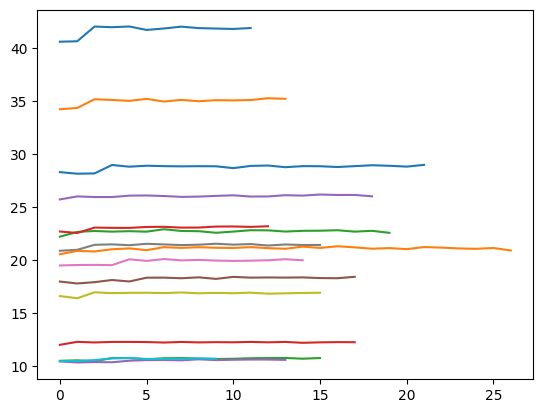

In [2]:
from matplotlib import pyplot as plt

for i in history['episodes_rewards']:
	plt.plot(history['episodes_rewards'][i])

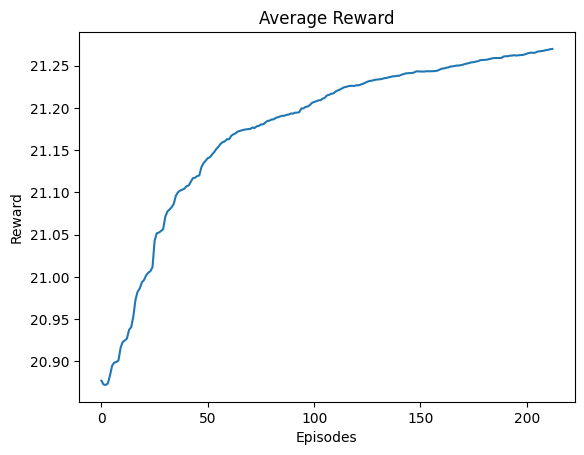

In [17]:
nice_index = [np.isnan(average_reward[i]) for i in range(len(average_reward))].index(True)
plt.title("Average Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(average_reward[nice_index + 1:])

In [12]:
np.isnan(average_reward[37])

True